<a href="https://colab.research.google.com/github/Yakupayaz/NLP/blob/master/NLP_Application_with_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Application with ML

## Classification of Tweets Data

### The Data

Source: https://www.kaggle.com/crowdflower/twitter-airline-sentiment?select=Tweets.csv

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
# !pip install scikit-learn-intelex
# from sklearnex import patch_sklearn
# patch_sklearn()

# Yerelde çalışıyorsan bu kütüphaneyle projeyi daha hızlı çalıştırırız.

In [89]:
!pip install autocorrect
!pip install contractions

In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from autocorrect import Speller
import contractions

import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('display.max_columns', 50)

In [91]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [92]:
df = pd.read_csv("/content/sample_data/airline_tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


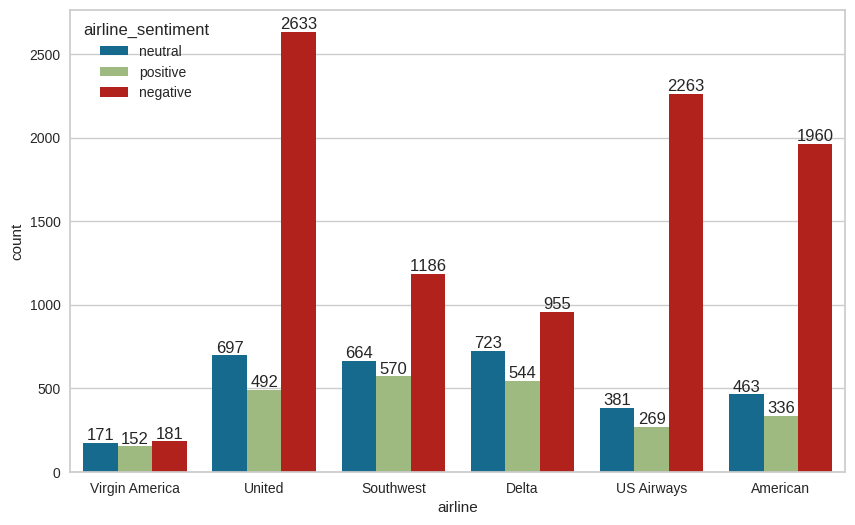

In [93]:
ax = sns.countplot(data = df, x ="airline", hue = "airline_sentiment")
for p in ax.containers:
    ax.bar_label(p)

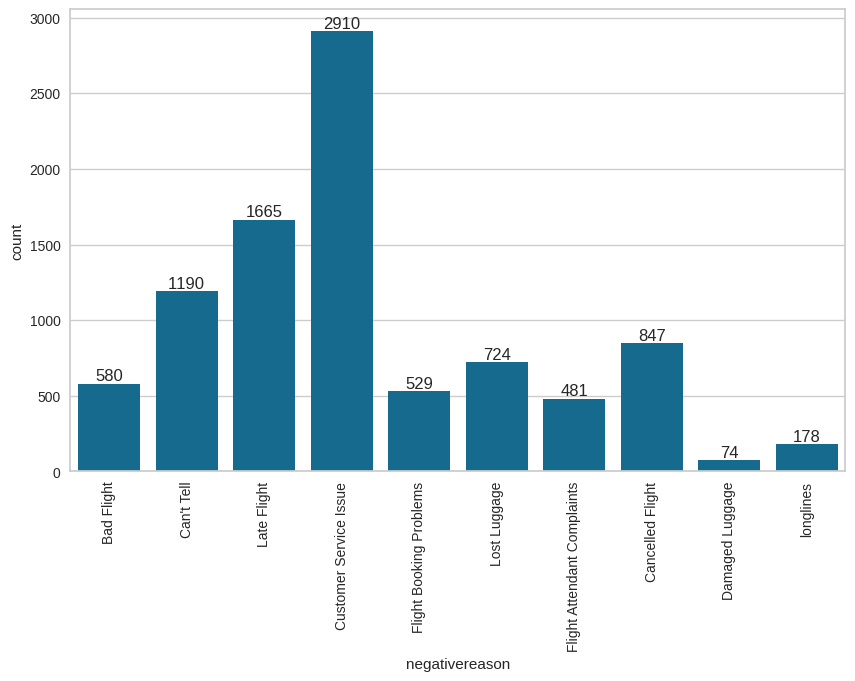

In [94]:
ax = sns.countplot(data =df, x ="negativereason")
ax.bar_label(ax.containers[0])
plt.xticks(rotation =90);

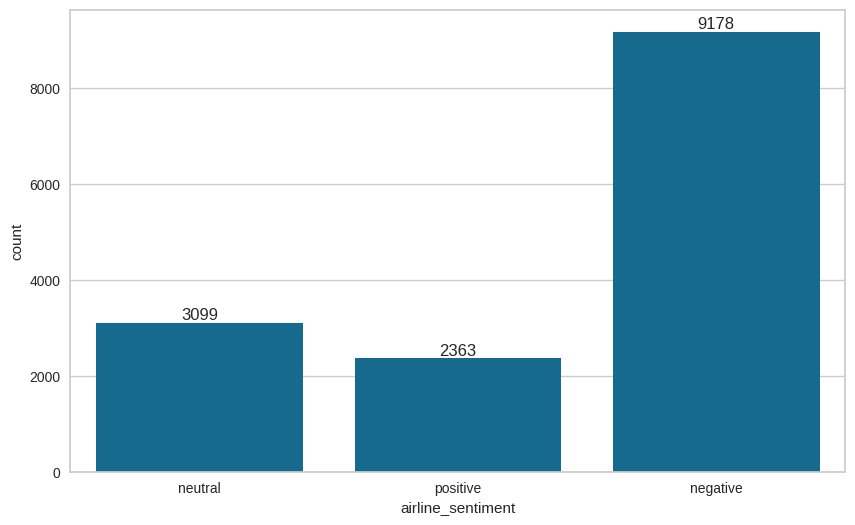

In [95]:
ax = sns.countplot(data =df, x = "airline_sentiment")
ax.bar_label(ax.containers[0]);

In [96]:
df["airline_sentiment"].value_counts()

,count
airline_sentiment,
negative,9178
neutral,3099
positive,2363


## Cleaning Data

In [97]:
df2 = df.copy()

In [98]:
df2["text"].head()

,text
0,@VirginAmerica What @dhepburn said.
1,@VirginAmerica plus you've added commercials t...
2,@VirginAmerica I didn't today... Must mean I n...
3,@VirginAmerica it's really aggressive to blast...
4,@VirginAmerica and it's a really big bad thing...


## Cleaning Data

In [99]:
import re
s = "http\\:www.mynet.com #lateflight @airlines"
s = re.sub("http\S+", "", s).strip()
s

'#lateflight @airlines'

In [100]:
s = re.sub("#\S*", "", s)
s

' @airlines'

In [101]:
s = re.sub("@\S+", "", s)
s.strip()

''

In [102]:
stop_words = stopwords.words('english')

for i in ["not", "no"]:
        stop_words.remove(i)

# Müşteri yorum analizi yapılacaksa no ve not gibi olumsuz kelimeleri çıkarmamak için
# stop_words kütüphanesinden çıkarıyoruz.

In [103]:
def cleaning(data):

    import re

    #1. Removing URLS
    data = re.sub('http\S*', '', data).strip()
    data = re.sub('www\S*', '', data).strip()

    #2. Removing Tags
    data = re.sub('#\S*', '', data).strip()

    #3. Removing Mentions
    data = re.sub('@\S*', '', data).strip()

    #4. Removing upper brackets to keep negative auxiliary verbs in text
    data = data.replace("'", "")

    #5. Tokenize
    text_tokens = word_tokenize(data.lower())

    #6. Remove Puncs and number
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]

    #7. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]

    #8. lemma
    text_cleaned = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]

    # 9. Correction of text
    # spell = Speller(fast= False)
    # correction_data = spell(data)

    #joining
    return " ".join(text_cleaned)

In [104]:
cleaning_text = df2["text"].apply(cleaning)
cleaning_text.head()

,text
0,said
1,plus youve added commercial experience tacky
2,didnt today must mean need take another trip
3,really aggressive blast obnoxious entertainmen...
4,really big bad thing


## Features and Label

In [105]:
df2 =df2[["airline_sentiment", "text"]]
df2.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


## Train Test Split

In [106]:
from sklearn.model_selection import train_test_split

In [107]:
X = df2["text"]
y= df2["airline_sentiment"]

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=101)

## Vectorization

In [109]:
from sklearn.feature_extraction.text import CountVectorizer

In [110]:
vectorizer = CountVectorizer(preprocessor=cleaning, min_df=3) # ngram_range=(1,3), max_features= 1500
X_train_count = vectorizer.fit_transform(X_train)
X_test_count = vectorizer.transform(X_test)

# min_df = 3    --> corpusumda 3'den daha az document'da (yorumda) geçen tokenleri ignore et.
# max_df = 1000 --> corpusumda 1000'den daha fazla document'da (yorumda) geçen tokenleri ignore et. (0.95, 1.0)
# max_features = 1500 --> corpusumda en sık kullanılan ilk 1500 feature (tokeni) dikkate al diğerlerini ignore et.
# max_df = 0.95 --> corpusum'daki yorumların en az %95'inde geçen tokenleri
# ignore eder.

# max_features ve max_df = 1000 kullanmamız pek mantıklı olmaz. Farkında olmadan birçok keyword'u
# çıkarmış olabiliriz. Onun için min_df ve max_df = (0.95, 1.0) kullanılmalı.

# ngram cümledeki isim tamlamaları, sıfat tamlamaları vb gibi kalıpları daha iyi öğrenilmesi için kullanılır.
# ngram=1 olarak tüm tokenleri birer birer ayırır. Çok, güzel, bir , TV
# ngram=2 olarak tüm tokenleri ikişer ikişer ayırır. Çok güzel, güzel bir, bir TV
# ngram=3 olarak tüm tokenleri üçer üçer ayırır. Çok güzel bir, güzel bir TV


In [111]:
 X_train_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

## Model Comparisons - Vectorization

In [112]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score

In [113]:
def eval(model, X_train, X_test):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print(confusion_matrix(y_test, y_pred))
    print("Test_Set")
    print(classification_report(y_test,y_pred))
    print("Train_Set")
    print(classification_report(y_train,y_pred_train))


## Naive Bayes

In [114]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

# BernoulliNB for binary model

In [115]:
nb = MultinomialNB(alpha=10)
nb.fit(X_train_count,y_train)

MultinomialNB(alpha=10)

In [116]:
print("NB MODEL")
eval(nb, X_train_count, X_test_count)

NB MODEL
[[1793   27   15]
 [ 467  129   24]
 [ 251   16  206]]
Test_Set
              precision    recall  f1-score   support

    negative       0.71      0.98      0.83      1835
     neutral       0.75      0.21      0.33       620
    positive       0.84      0.44      0.57       473

    accuracy                           0.73      2928
   macro avg       0.77      0.54      0.57      2928
weighted avg       0.74      0.73      0.68      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.72      0.98      0.83      7343
     neutral       0.80      0.25      0.38      2479
    positive       0.86      0.44      0.58      1890

    accuracy                           0.74     11712
   macro avg       0.79      0.56      0.60     11712
weighted avg       0.76      0.74      0.70     11712



In [117]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

scoring = {'accuracy': make_scorer(accuracy_score),
            'precision-neg': make_scorer(precision_score, average=None, labels=["negative"]),
            'recall-neg': make_scorer(recall_score, average=None, labels = ["negative"]),
            'f1-neg': make_scorer(f1_score, average=None, labels = ["negative"])}

model = MultinomialNB(alpha=10)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

,0
test_accuracy,0.714482
train_accuracy,0.734147
test_precision-neg,0.704816
train_precision-neg,0.717316
test_recall-neg,0.978891
train_recall-neg,0.984293
test_f1-neg,0.819534
train_f1-neg,0.829860


In [118]:
!pip install --upgrade scikit-plot

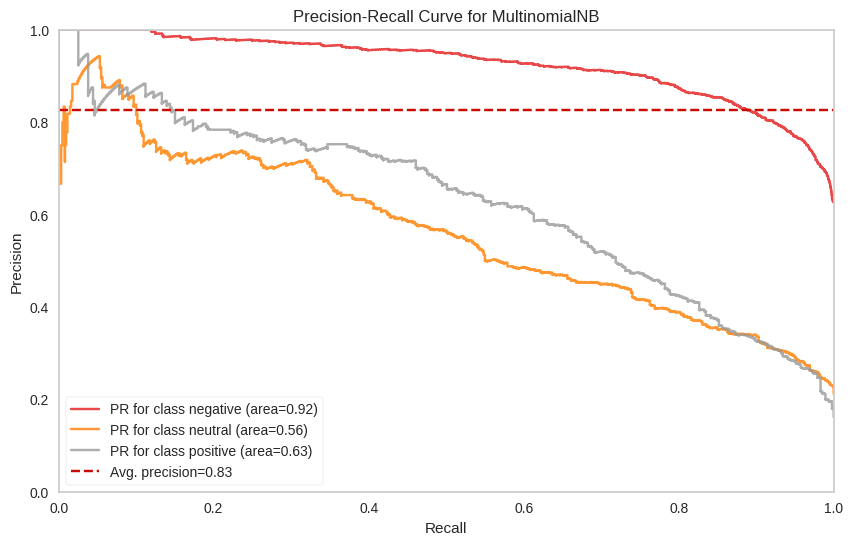

In [119]:
from yellowbrick.classifier import PrecisionRecallCurve

viz = PrecisionRecallCurve(
    MultinomialNB(alpha=10),
    classes=nb.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [120]:
y_pred = nb.predict(X_test_count)
nb_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
nb_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
nb_AP_neg = viz.score_["negative"]

## Logistic Regression

In [121]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(C = 0.02, max_iter=1000) #class_weight='balanced'
log.fit(X_train_count,y_train)

LogisticRegression(C=0.02, max_iter=1000)

In [122]:
print("LOG MODEL")
eval(log, X_train_count, X_test_count)

LOG MODEL
[[1759   40   36]
 [ 366  211   43]
 [ 177   47  249]]
Test_Set
              precision    recall  f1-score   support

    negative       0.76      0.96      0.85      1835
     neutral       0.71      0.34      0.46       620
    positive       0.76      0.53      0.62       473

    accuracy                           0.76      2928
   macro avg       0.74      0.61      0.64      2928
weighted avg       0.75      0.76      0.73      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.77      0.97      0.86      7343
     neutral       0.76      0.41      0.53      2479
    positive       0.79      0.51      0.62      1890

    accuracy                           0.77     11712
   macro avg       0.77      0.63      0.67     11712
weighted avg       0.77      0.77      0.75     11712



In [123]:
model = LogisticRegression(C = 0.02, max_iter=1000)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

,0
test_accuracy,0.745731
train_accuracy,0.765198
test_precision-neg,0.747621
train_precision-neg,0.761601
test_recall-neg,0.963501
train_recall-neg,0.970705
test_f1-neg,0.841924
train_f1-neg,0.853532


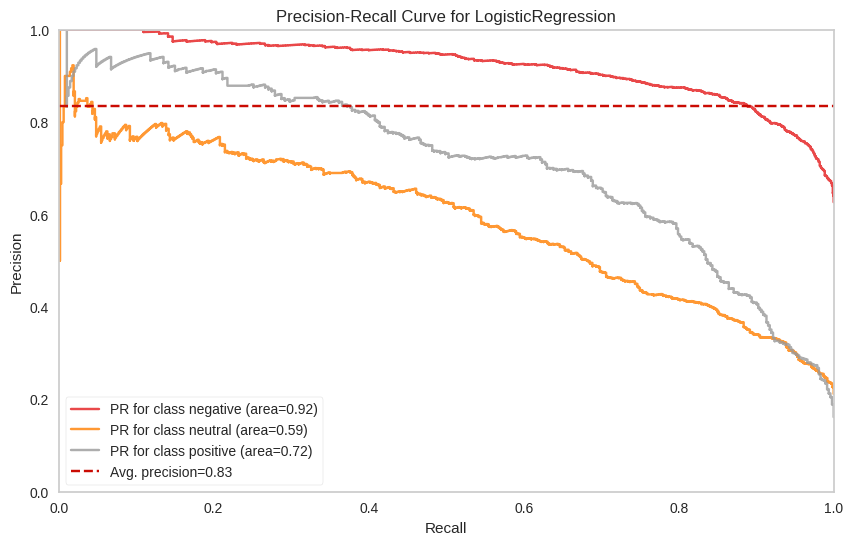

In [124]:
viz = PrecisionRecallCurve(
    LogisticRegression(C = 0.02, max_iter=1000),
    classes=log.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [125]:
y_pred = log.predict(X_test_count)
log_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
log_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
log_AP_neg = viz.score_["negative"]

#Balanced Logistic Regression

In [126]:
log = LogisticRegression(C = 0.02, max_iter=1000, class_weight='balanced')
log.fit(X_train_count,y_train)

# Genellikle azınlık olan sınıfın değerlerini iyileştirmek için kullanılır. Burda kullanılmaya gerek yok.

LogisticRegression(C=0.02, class_weight='balanced', max_iter=1000)

In [127]:
print("LOG MODEL BALANCED")
eval(log, X_train_count, X_test_count)

LOG MODEL BALANCED
[[1302  435   98]
 [  98  447   75]
 [  34   96  343]]
Test_Set
              precision    recall  f1-score   support

    negative       0.91      0.71      0.80      1835
     neutral       0.46      0.72      0.56       620
    positive       0.66      0.73      0.69       473

    accuracy                           0.71      2928
   macro avg       0.68      0.72      0.68      2928
weighted avg       0.77      0.71      0.73      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.93      0.74      0.82      7343
     neutral       0.51      0.78      0.62      2479
    positive       0.67      0.75      0.71      1890

    accuracy                           0.75     11712
   macro avg       0.70      0.75      0.72     11712
weighted avg       0.80      0.75      0.76     11712



## SVM

In [128]:
from sklearn.svm import LinearSVC
svc = LinearSVC(C=0.01)
svc.fit(X_train_count,y_train)

# LinearSVC kullanmamızın sebebi Logistic Regression değerinin yüksek olmasıdır.
# %90 veri setlerinde eğer logistic değer neyse linearSVC'de ona yakın bir değer verir.

LinearSVC(C=0.01)

In [129]:
print("SVC MODEL")
eval(svc, X_train_count, X_test_count)

SVC MODEL
[[1711   80   44]
 [ 291  279   50]
 [ 124   50  299]]
Test_Set
              precision    recall  f1-score   support

    negative       0.80      0.93      0.86      1835
     neutral       0.68      0.45      0.54       620
    positive       0.76      0.63      0.69       473

    accuracy                           0.78      2928
   macro avg       0.75      0.67      0.70      2928
weighted avg       0.77      0.78      0.77      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.83      0.95      0.89      7343
     neutral       0.76      0.55      0.64      2479
    positive       0.80      0.63      0.70      1890

    accuracy                           0.82     11712
   macro avg       0.80      0.71      0.74     11712
weighted avg       0.81      0.82      0.81     11712



In [130]:
model = LinearSVC(C=0.01)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

,0
test_accuracy,0.777494
train_accuracy,0.816475
test_precision-neg,0.799702
train_precision-neg,0.828654
test_recall-neg,0.939396
train_recall-neg,0.957087
test_f1-neg,0.863922
train_f1-neg,0.888251


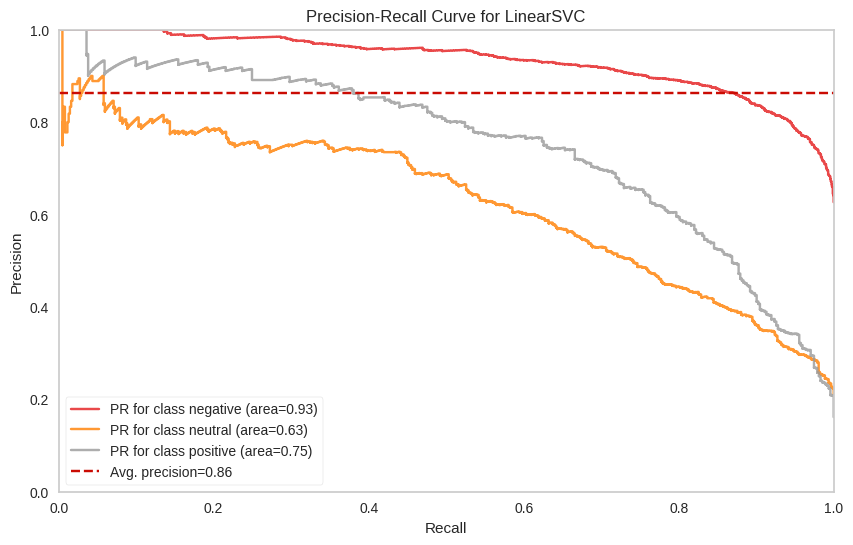

In [131]:
viz = PrecisionRecallCurve(
    LinearSVC(C=0.01),
    classes=svc.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [132]:
y_pred = svc.predict(X_test_count)
svc_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
svc_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
svc_AP_neg = viz.score_["negative"]

## KNN

In [133]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_count,y_train)

KNeighborsClassifier(n_neighbors=7)

In [134]:
print("KNN MODEL")
eval(knn, X_train_count, X_test_count)

KNN MODEL
[[912 839  84]
 [113 447  60]
 [ 46 178 249]]
Test_Set
              precision    recall  f1-score   support

    negative       0.85      0.50      0.63      1835
     neutral       0.31      0.72      0.43       620
    positive       0.63      0.53      0.58       473

    accuracy                           0.55      2928
   macro avg       0.60      0.58      0.54      2928
weighted avg       0.70      0.55      0.58      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.90      0.62      0.73      7343
     neutral       0.39      0.82      0.53      2479
    positive       0.70      0.56      0.62      1890

    accuracy                           0.65     11712
   macro avg       0.66      0.66      0.63     11712
weighted avg       0.76      0.65      0.67     11712



In [135]:
model = KNeighborsClassifier(n_neighbors=7)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

,0
test_accuracy,0.530654
train_accuracy,0.646099
test_precision-neg,0.846802
train_precision-neg,0.903680
test_recall-neg,0.466436
train_recall-neg,0.609394
test_f1-neg,0.601124
train_f1-neg,0.727858


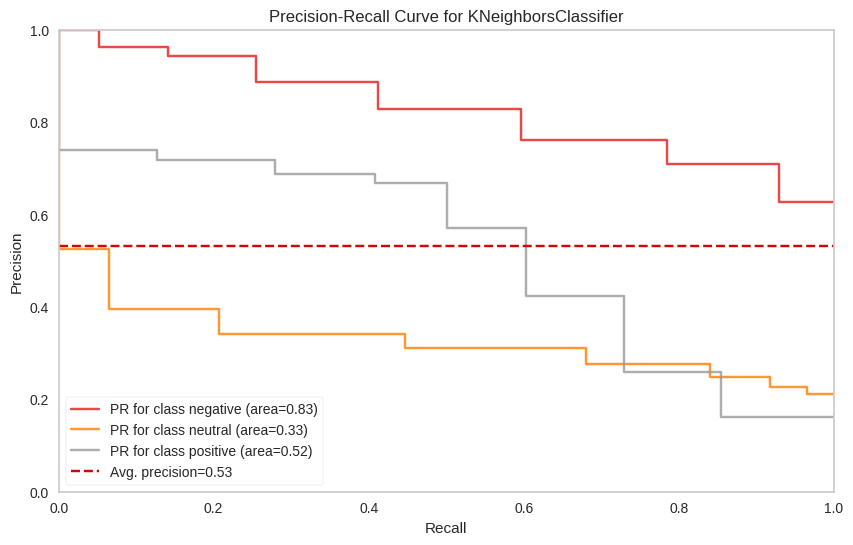

In [136]:
viz = PrecisionRecallCurve(
    KNeighborsClassifier(n_neighbors=7),
    classes=knn.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [137]:
y_pred = knn.predict(X_test_count)
knn_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
knn_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
knn_AP_neg = viz.score_["negative"]

## Random Forest

In [138]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(100, max_depth = 40, random_state = 42, n_jobs = -1) # class_weight="balanced"
rf.fit(X_train_count, y_train)

RandomForestClassifier(max_depth=40, n_jobs=-1, random_state=42)

In [139]:
print("RF MODEL")
eval(rf, X_train_count, X_test_count)

RF MODEL
[[1798   11   26]
 [ 523   59   38]
 [ 219    7  247]]
Test_Set
              precision    recall  f1-score   support

    negative       0.71      0.98      0.82      1835
     neutral       0.77      0.10      0.17       620
    positive       0.79      0.52      0.63       473

    accuracy                           0.72      2928
   macro avg       0.76      0.53      0.54      2928
weighted avg       0.73      0.72      0.65      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.74      1.00      0.85      7343
     neutral       0.97      0.20      0.34      2479
    positive       0.92      0.63      0.75      1890

    accuracy                           0.77     11712
   macro avg       0.88      0.61      0.64     11712
weighted avg       0.82      0.77      0.72     11712



In [140]:
model = RandomForestClassifier(100, max_depth = 40, random_state = 42, n_jobs = -1)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

,0
test_accuracy,0.710040
train_accuracy,0.774059
test_precision-neg,0.698911
train_precision-neg,0.742447
test_recall-neg,0.984338
train_recall-neg,0.997397
test_f1-neg,0.817418
train_f1-neg,0.851242


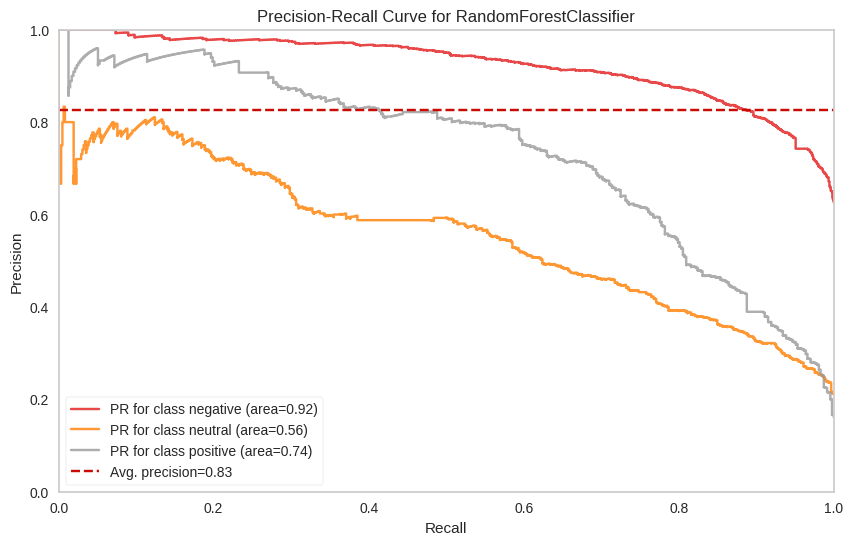

In [141]:
viz = PrecisionRecallCurve(
    RandomForestClassifier(100, max_depth = 40, random_state = 42, n_jobs = -1),
    classes=rf.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [142]:
y_pred = rf.predict(X_test_count)
rf_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
rf_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
rf_AP_neg = viz.score_["negative"]

In [143]:
rf = RandomForestClassifier(100, max_depth = 40, random_state = 42, n_jobs = -1, class_weight="balanced")
rf.fit(X_train_count, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=40, n_jobs=-1,
                       random_state=42)

In [144]:
print("RF MODEL BALANCED")
eval(rf, X_train_count, X_test_count)

RF MODEL BALANCED
[[1455  305   75]
 [ 152  403   65]
 [  53   97  323]]
Test_Set
              precision    recall  f1-score   support

    negative       0.88      0.79      0.83      1835
     neutral       0.50      0.65      0.57       620
    positive       0.70      0.68      0.69       473

    accuracy                           0.74      2928
   macro avg       0.69      0.71      0.70      2928
weighted avg       0.77      0.74      0.75      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.97      0.85      0.91      7343
     neutral       0.64      0.90      0.75      2479
    positive       0.87      0.82      0.85      1890

    accuracy                           0.86     11712
   macro avg       0.83      0.86      0.83     11712
weighted avg       0.89      0.86      0.86     11712



## Ada Boost

In [145]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators= 500, random_state = 42)
ada.fit(X_train_count, y_train)

AdaBoostClassifier(n_estimators=500, random_state=42)

In [146]:
print("Ada MODEL")
eval(ada, X_train_count, X_test_count)

Ada MODEL
[[1555  205   75]
 [ 210  339   71]
 [  86   72  315]]
Test_Set
              precision    recall  f1-score   support

    negative       0.84      0.85      0.84      1835
     neutral       0.55      0.55      0.55       620
    positive       0.68      0.67      0.67       473

    accuracy                           0.75      2928
   macro avg       0.69      0.69      0.69      2928
weighted avg       0.75      0.75      0.75      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.87      0.88      0.87      7343
     neutral       0.61      0.62      0.62      2479
    positive       0.79      0.71      0.75      1890

    accuracy                           0.80     11712
   macro avg       0.75      0.74      0.75     11712
weighted avg       0.80      0.80      0.80     11712



In [147]:
model = AdaBoostClassifier(n_estimators= 500, random_state = 42)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

,0
test_accuracy,0.759136
train_accuracy,0.802131
test_precision-neg,0.842861
train_precision-neg,0.866759
test_recall-neg,0.856597
train_recall-neg,0.883699
test_f1-neg,0.849649
train_f1-neg,0.875144


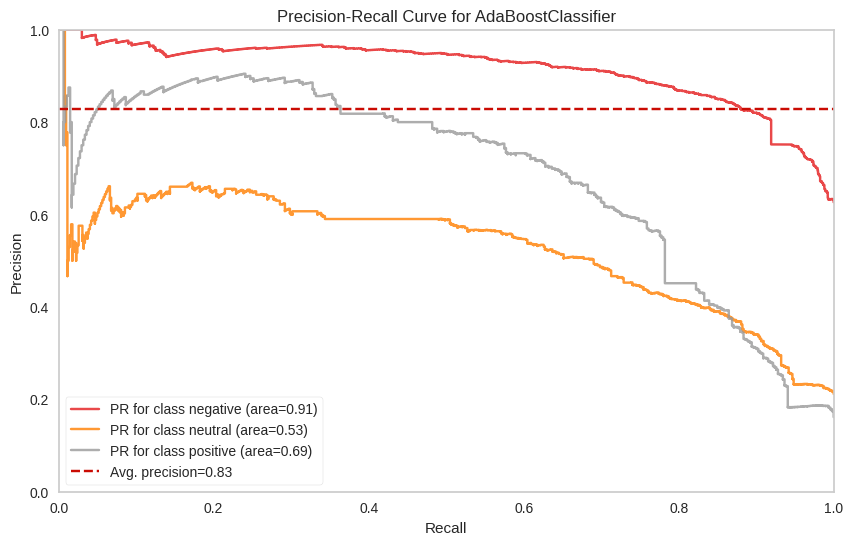

In [148]:
viz = PrecisionRecallCurve(
    AdaBoostClassifier(n_estimators= 500, random_state = 42),
    classes=ada.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [149]:
y_pred = ada.predict(X_test_count)
ada_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
ada_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
ada_AP_neg = viz.score_["negative"]

## TF-IDF

In [150]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [151]:
tf_idf_vectorizer = TfidfVectorizer(preprocessor=cleaning, min_df=3)
X_train_tf_idf = tf_idf_vectorizer.fit_transform(X_train)
X_test_tf_idf = tf_idf_vectorizer.transform(X_test)

## Model Comparisons  TF-IDF

## Naive Bayes

In [153]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

nb = MultinomialNB()
nb.fit(X_train_tf_idf,y_train)

MultinomialNB()

In [154]:
print("NB MODEL")
eval(nb, X_train_tf_idf, X_test_tf_idf)

NB MODEL
[[1802   25    8]
 [ 426  172   22]
 [ 248   31  194]]
Test_Set
              precision    recall  f1-score   support

    negative       0.73      0.98      0.84      1835
     neutral       0.75      0.28      0.41       620
    positive       0.87      0.41      0.56       473

    accuracy                           0.74      2928
   macro avg       0.78      0.56      0.60      2928
weighted avg       0.76      0.74      0.70      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.75      0.99      0.85      7343
     neutral       0.84      0.35      0.50      2479
    positive       0.91      0.51      0.65      1890

    accuracy                           0.78     11712
   macro avg       0.84      0.62      0.67     11712
weighted avg       0.80      0.78      0.75     11712



In [155]:
model = MultinomialNB()
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

,0
test_accuracy,0.731643
train_accuracy,0.774277
test_precision-neg,0.721593
train_precision-neg,0.751007
test_recall-neg,0.978890
train_recall-neg,0.988818
test_f1-neg,0.830756
train_f1-neg,0.853659


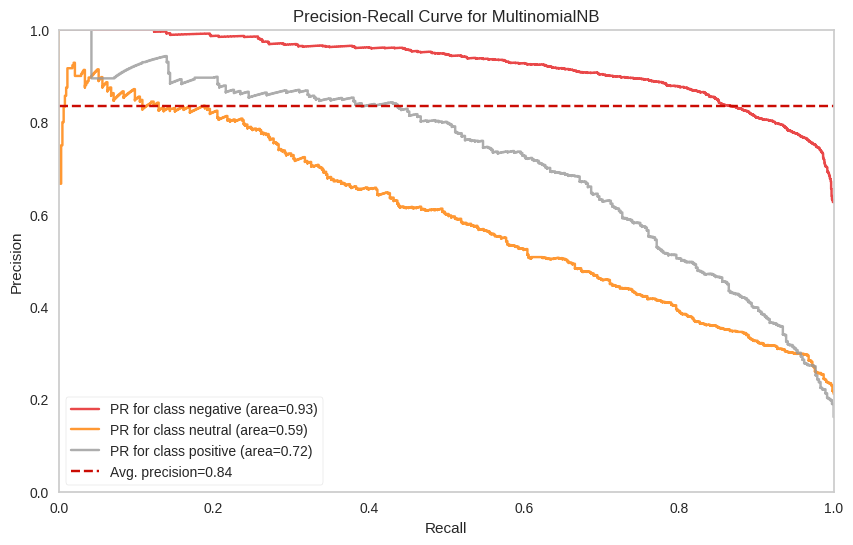

In [156]:
viz = PrecisionRecallCurve(
    MultinomialNB(),
    classes=nb.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show();

In [157]:
y_pred = nb.predict(X_test_tf_idf)
nb_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
nb_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
nb_tfidf_AP_neg = viz.score_["negative"]

## Logistic Regression

In [158]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(C=0.4, max_iter=1000)
log.fit(X_train_tf_idf,y_train)

LogisticRegression(C=0.4, max_iter=1000)

In [159]:
print("LOG MODEL")
eval(log, X_train_tf_idf, X_test_tf_idf)

LOG MODEL
[[1757   51   27]
 [ 332  256   32]
 [ 144   47  282]]
Test_Set
              precision    recall  f1-score   support

    negative       0.79      0.96      0.86      1835
     neutral       0.72      0.41      0.53       620
    positive       0.83      0.60      0.69       473

    accuracy                           0.78      2928
   macro avg       0.78      0.66      0.69      2928
weighted avg       0.78      0.78      0.76      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.82      0.97      0.89      7343
     neutral       0.82      0.53      0.64      2479
    positive       0.87      0.62      0.73      1890

    accuracy                           0.82     11712
   macro avg       0.84      0.71      0.75     11712
weighted avg       0.83      0.82      0.81     11712



In [160]:
model = LogisticRegression(C=0.4, max_iter=1000)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

,0
test_accuracy,0.771432
train_accuracy,0.821200
test_precision-neg,0.776135
train_precision-neg,0.813160
test_recall-neg,0.960506
train_recall-neg,0.976818
test_f1-neg,0.858515
train_f1-neg,0.887507


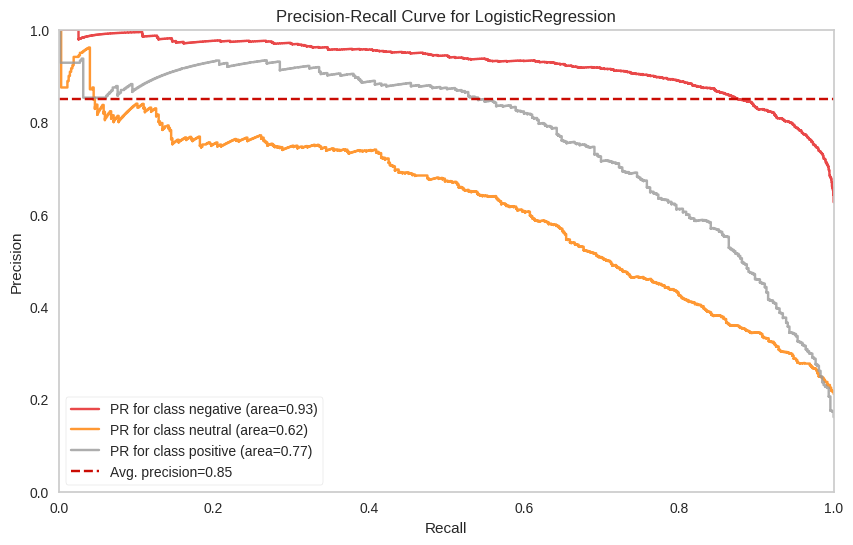

In [161]:
viz = PrecisionRecallCurve(
    LogisticRegression(C=0.4, max_iter=1000),
    classes=log.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show();

In [162]:
y_pred = log.predict(X_test_tf_idf)
log_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
log_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
log_tfidf_AP_neg = viz.score_["negative"]

In [163]:
log = LogisticRegression(C=0.4, max_iter=1000, class_weight="balanced")
log.fit(X_train_tf_idf,y_train)

LogisticRegression(C=0.4, class_weight='balanced', max_iter=1000)

In [164]:
print("LOG MODEL BALANCED")
eval(log, X_train_tf_idf, X_test_tf_idf)

LOG MODEL BALANCED
[[1432  304   99]
 [ 121  427   72]
 [  39   71  363]]
Test_Set
              precision    recall  f1-score   support

    negative       0.90      0.78      0.84      1835
     neutral       0.53      0.69      0.60       620
    positive       0.68      0.77      0.72       473

    accuracy                           0.76      2928
   macro avg       0.70      0.75      0.72      2928
weighted avg       0.79      0.76      0.77      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.94      0.81      0.87      7343
     neutral       0.61      0.80      0.69      2479
    positive       0.74      0.84      0.79      1890

    accuracy                           0.81     11712
   macro avg       0.76      0.82      0.78     11712
weighted avg       0.84      0.81      0.82     11712



## SVM

In [165]:
from sklearn.svm import LinearSVC
svc = LinearSVC(C=0.1)
svc.fit(X_train_tf_idf,y_train)

LinearSVC(C=0.1)

In [166]:
print("SVC MODEL")
eval(svc, X_train_tf_idf, X_test_tf_idf)

SVC MODEL
[[1737   64   34]
 [ 312  263   45]
 [ 124   44  305]]
Test_Set
              precision    recall  f1-score   support

    negative       0.80      0.95      0.87      1835
     neutral       0.71      0.42      0.53       620
    positive       0.79      0.64      0.71       473

    accuracy                           0.79      2928
   macro avg       0.77      0.67      0.70      2928
weighted avg       0.78      0.79      0.77      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.84      0.97      0.90      7343
     neutral       0.83      0.56      0.67      2479
    positive       0.87      0.68      0.76      1890

    accuracy                           0.84     11712
   macro avg       0.84      0.74      0.78     11712
weighted avg       0.84      0.84      0.83     11712



In [167]:
model = LinearSVC(C=0.1)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

,0
test_accuracy,0.781934
train_accuracy,0.838010
test_precision-neg,0.790352
train_precision-neg,0.832907
test_recall-neg,0.956965
train_recall-neg,0.974897
test_f1-neg,0.865677
train_f1-neg,0.898323


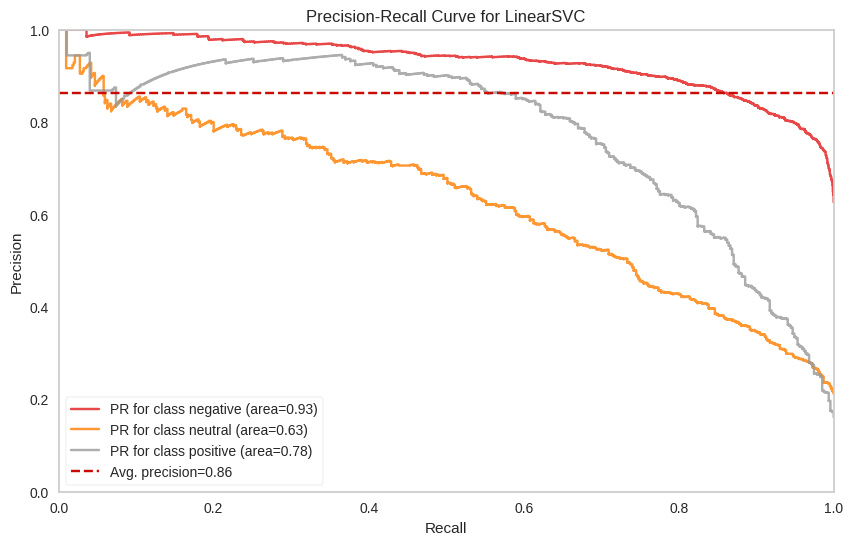

In [168]:
viz = PrecisionRecallCurve(
    LinearSVC(C=0.1),
    classes=svc.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show();

In [169]:
y_pred = svc.predict(X_test_tf_idf)
svc_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
svc_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
svc_tfidf_AP_neg = viz.score_["negative"]

## KNN

In [170]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_tf_idf,y_train)

KNeighborsClassifier(n_neighbors=7)

In [171]:
print("KNN MODEL")
eval(knn, X_train_tf_idf, X_test_tf_idf)

KNN MODEL
[[  77 1756    2]
 [  18  588   14]
 [   5  378   90]]
Test_Set
              precision    recall  f1-score   support

    negative       0.77      0.04      0.08      1835
     neutral       0.22      0.95      0.35       620
    positive       0.85      0.19      0.31       473

    accuracy                           0.26      2928
   macro avg       0.61      0.39      0.25      2928
weighted avg       0.67      0.26      0.17      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.88      0.07      0.12      7343
     neutral       0.22      0.97      0.36      2479
    positive       0.88      0.21      0.34      1890

    accuracy                           0.28     11712
   macro avg       0.66      0.41      0.28     11712
weighted avg       0.74      0.28      0.21     11712



In [172]:
model = KNeighborsClassifier(n_neighbors=7)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

,0
test_accuracy,0.260327
train_accuracy,0.330719
test_precision-neg,0.801795
train_precision-neg,0.896092
test_recall-neg,0.049695
train_recall-neg,0.148178
test_f1-neg,0.090990
train_f1-neg,0.197470


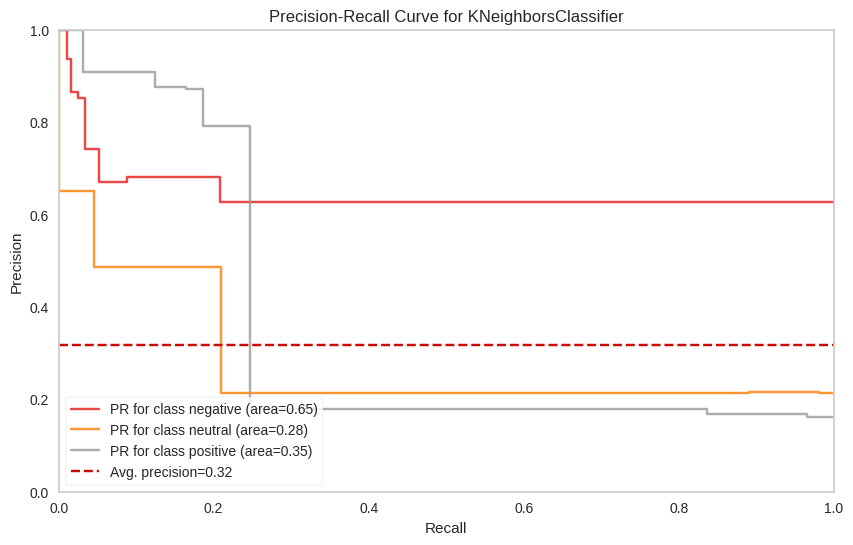

In [173]:
viz = PrecisionRecallCurve(
    KNeighborsClassifier(n_neighbors=7),
    classes=knn.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show();

In [174]:
y_pred = knn.predict(X_test_tf_idf)
knn_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
knn_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
knn_tfidf_AP_neg = viz.score_["negative"]

## RandomForest

In [175]:
rf = RandomForestClassifier(100, max_depth=40, random_state = 42, n_jobs = -1)
rf.fit(X_train_tf_idf, y_train)

RandomForestClassifier(max_depth=40, n_jobs=-1, random_state=42)

In [176]:
print("RF MODEL")
eval(rf, X_train_tf_idf, X_test_tf_idf)

RF MODEL
[[1805   10   20]
 [ 532   53   35]
 [ 242    7  224]]
Test_Set
              precision    recall  f1-score   support

    negative       0.70      0.98      0.82      1835
     neutral       0.76      0.09      0.15       620
    positive       0.80      0.47      0.60       473

    accuracy                           0.71      2928
   macro avg       0.75      0.51      0.52      2928
weighted avg       0.73      0.71      0.64      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.73      1.00      0.84      7343
     neutral       0.98      0.21      0.34      2479
    positive       0.94      0.58      0.72      1890

    accuracy                           0.76     11712
   macro avg       0.88      0.60      0.64     11712
weighted avg       0.82      0.76      0.72     11712



In [177]:
model = RandomForestClassifier(100, max_depth=40, random_state = 42, n_jobs = -1)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

,0
test_accuracy,0.707565
train_accuracy,0.766204
test_precision-neg,0.694344
train_precision-neg,0.733642
test_recall-neg,0.988288
train_recall-neg,0.998199
test_f1-neg,0.815631
train_f1-neg,0.845712


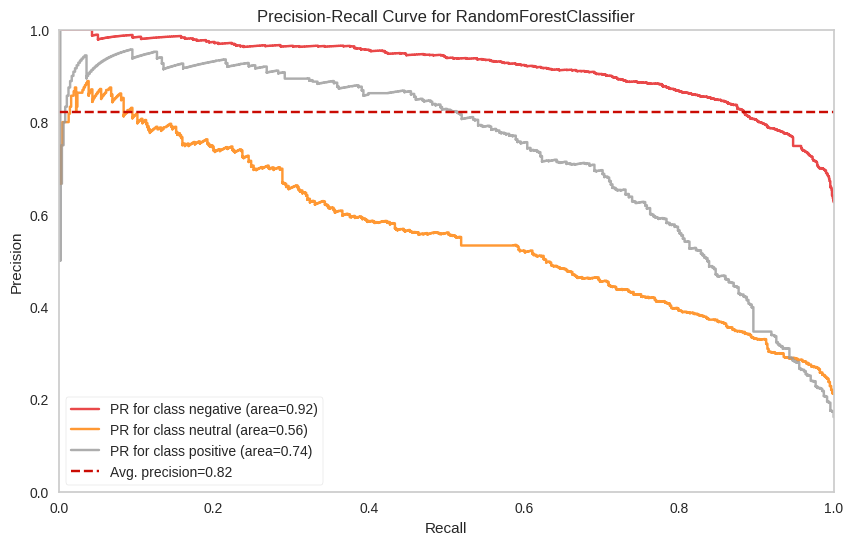

In [178]:
viz = PrecisionRecallCurve(
    RandomForestClassifier(100, max_depth=40, random_state = 42, n_jobs = -1),
    classes=rf.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show();

In [179]:
y_pred = rf.predict(X_test_tf_idf)
rf_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
rf_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
rf_tfidf_AP_neg = viz.score_["negative"]

In [180]:
rf = RandomForestClassifier(100, max_depth=15, random_state = 42, n_jobs = -1, class_weight="balanced")
rf.fit(X_train_tf_idf, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15, n_jobs=-1,
                       random_state=42)

In [181]:
print("RF MODEL BALANCED")
eval(rf, X_train_tf_idf, X_test_tf_idf)

RF MODEL BALANCED
[[1353  386   96]
 [ 129  423   68]
 [  47  108  318]]
Test_Set
              precision    recall  f1-score   support

    negative       0.88      0.74      0.80      1835
     neutral       0.46      0.68      0.55       620
    positive       0.66      0.67      0.67       473

    accuracy                           0.72      2928
   macro avg       0.67      0.70      0.67      2928
weighted avg       0.76      0.72      0.73      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.93      0.76      0.84      7343
     neutral       0.52      0.81      0.63      2479
    positive       0.74      0.72      0.73      1890

    accuracy                           0.77     11712
   macro avg       0.73      0.76      0.73     11712
weighted avg       0.81      0.77      0.78     11712



## Ada Boost

In [182]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators= 500, random_state = 42)
ada.fit(X_train_tf_idf, y_train)

AdaBoostClassifier(n_estimators=500, random_state=42)

In [183]:
print("Ada MODEL")
eval(ada, X_train_tf_idf, X_test_tf_idf)

Ada MODEL
[[1536  226   73]
 [ 228  331   61]
 [  99   73  301]]
Test_Set
              precision    recall  f1-score   support

    negative       0.82      0.84      0.83      1835
     neutral       0.53      0.53      0.53       620
    positive       0.69      0.64      0.66       473

    accuracy                           0.74      2928
   macro avg       0.68      0.67      0.67      2928
weighted avg       0.74      0.74      0.74      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.85      0.88      0.87      7343
     neutral       0.62      0.62      0.62      2479
    positive       0.83      0.73      0.77      1890

    accuracy                           0.80     11712
   macro avg       0.77      0.74      0.75     11712
weighted avg       0.80      0.80      0.80     11712



In [184]:
model = AdaBoostClassifier(n_estimators= 500, random_state = 42)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

,0
test_accuracy,0.739755
train_accuracy,0.796287
test_precision-neg,0.823338
train_precision-neg,0.851597
test_recall-neg,0.843797
train_recall-neg,0.874574
test_f1-neg,0.833389
train_f1-neg,0.862921


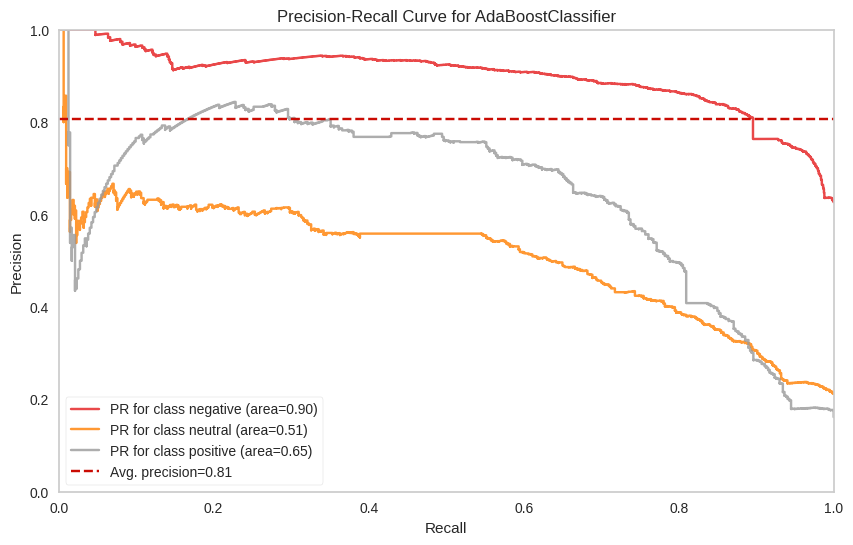

In [185]:
viz = PrecisionRecallCurve(
    AdaBoostClassifier(n_estimators= 500, random_state = 42),
    classes=ada.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show();

In [186]:
y_pred = ada.predict(X_test_tf_idf)
ada_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
ada_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
ada_tfidf_AP_neg = viz.score_["negative"]

In [187]:
nb_count_f1_neg

array([0.82512655])

## Compare Scoring

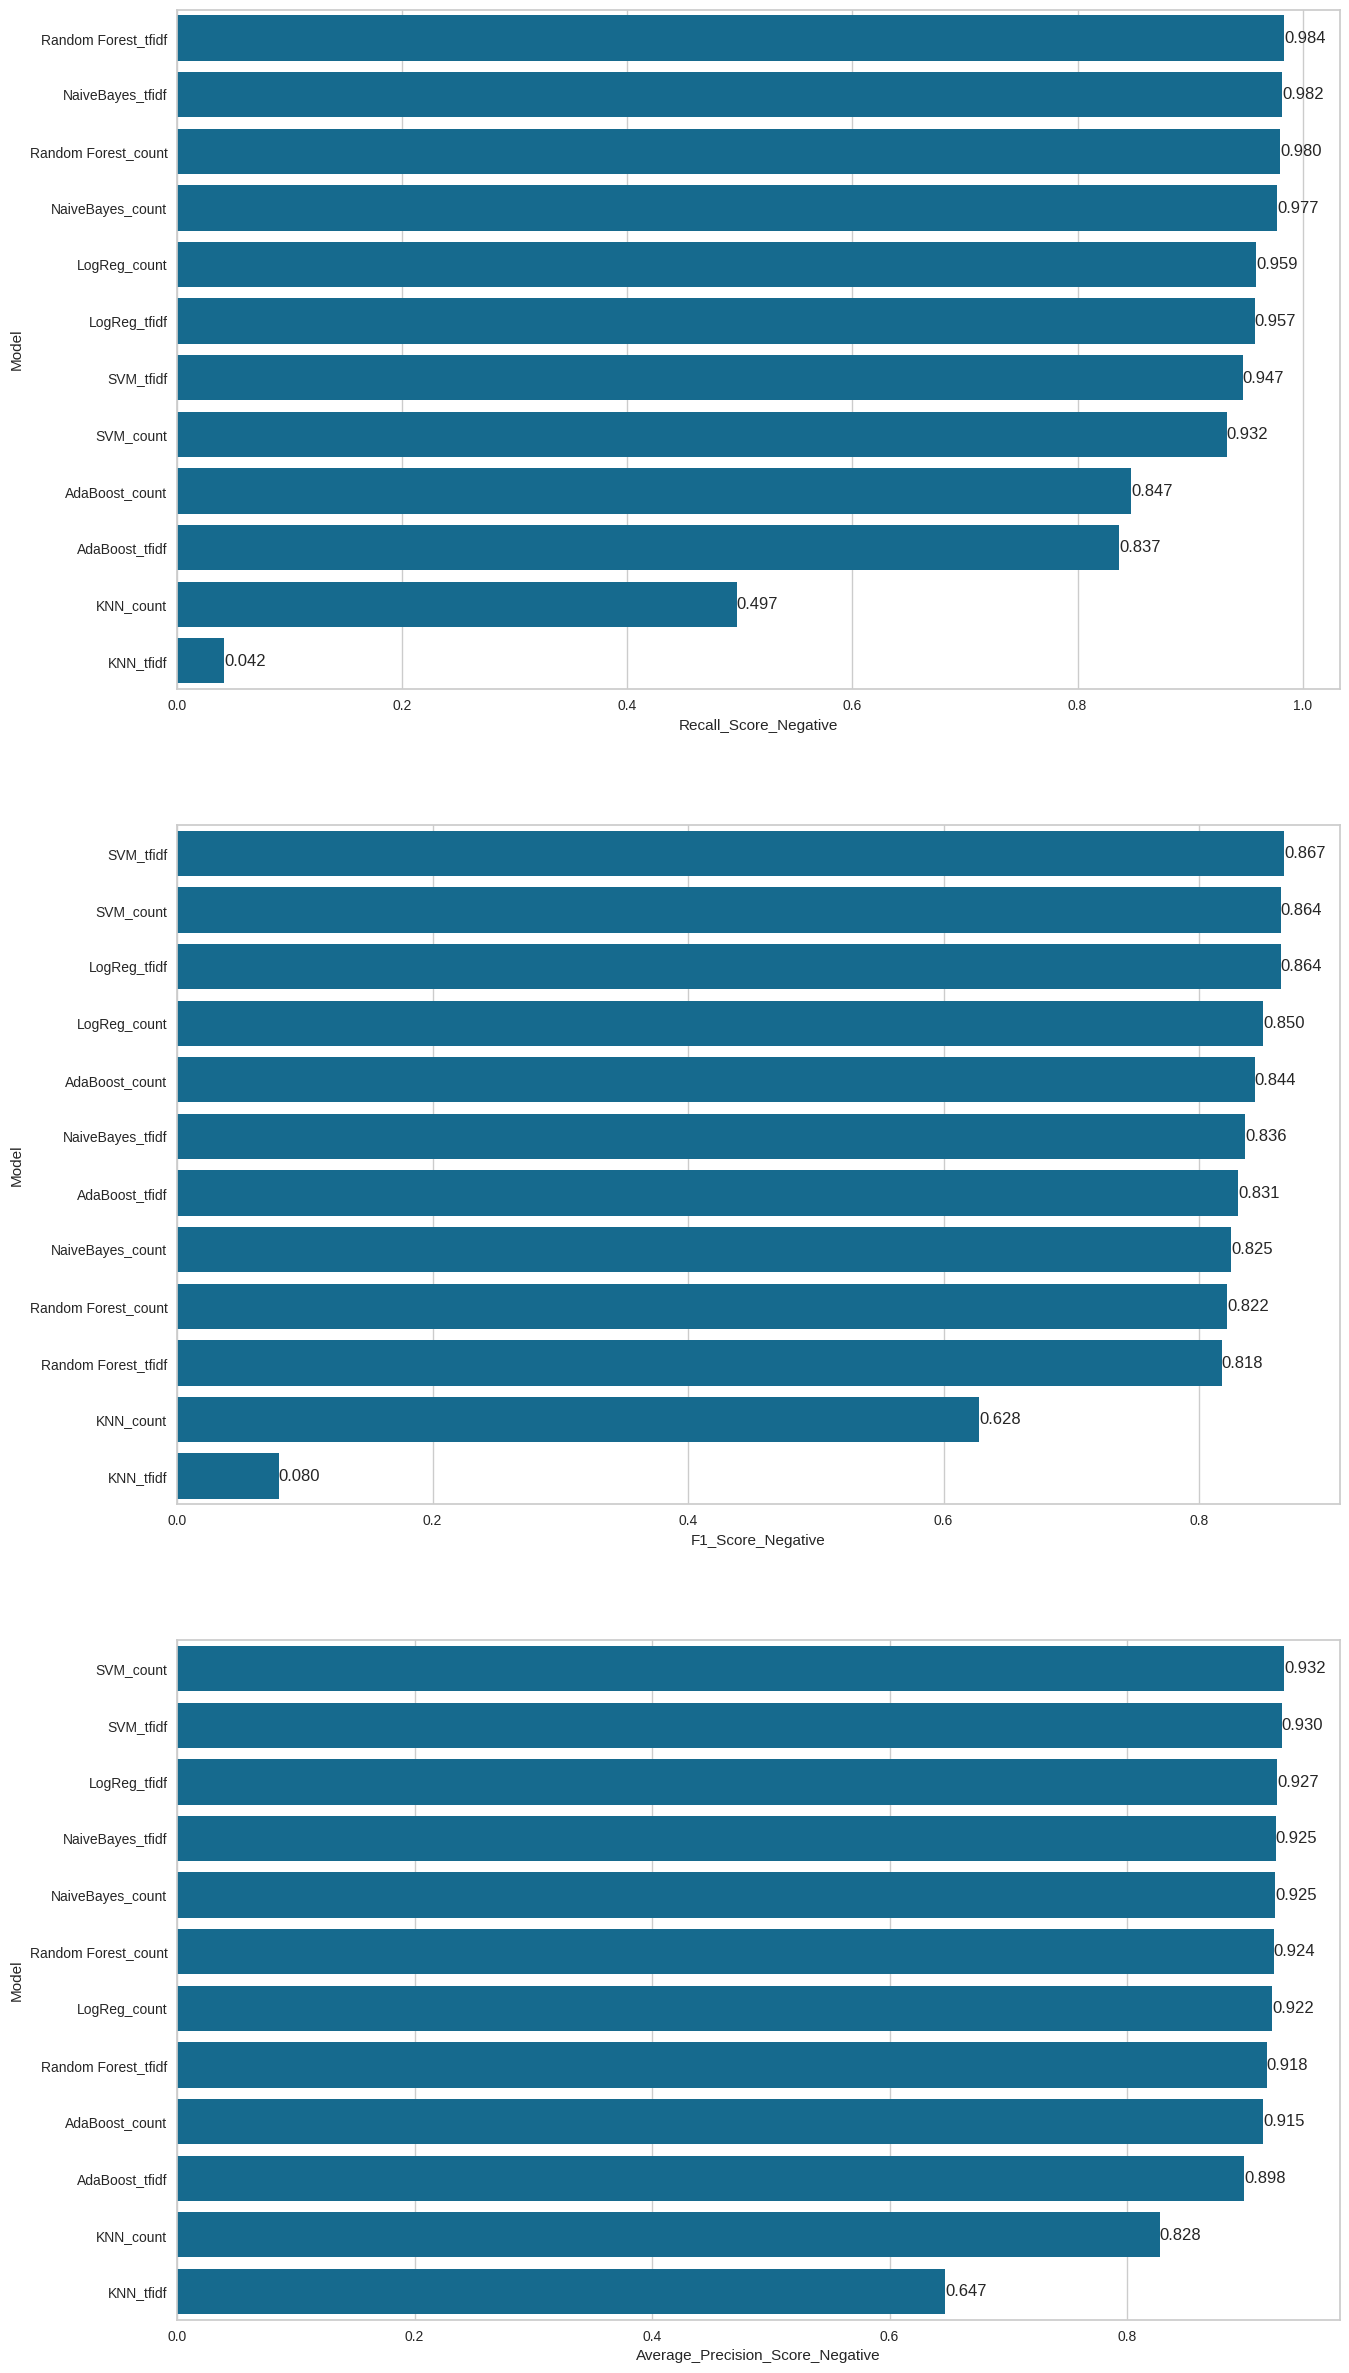

In [189]:
compare = pd.DataFrame({"Model": ["NaiveBayes_count", "LogReg_count", "SVM_count", "KNN_count", "Random Forest_count",
                                  "AdaBoost_count", "NaiveBayes_tfidf", "LogReg_tfidf", "SVM_tfidf", "KNN_tfidf",
                                  "Random Forest_tfidf", "AdaBoost_tfidf"],

                        "F1_Score_Negative": [nb_count_f1_neg[0], log_count_f1_neg[0], svc_count_f1_neg[0], knn_count_f1_neg[0],
                                             rf_count_f1_neg[0], ada_count_f1_neg[0], nb_tfidf_f1_neg[0], log_tfidf_f1_neg[0],
                                             svc_tfidf_f1_neg[0], knn_tfidf_f1_neg[0], rf_tfidf_f1_neg[0], ada_tfidf_f1_neg[0]],

                        "Recall_Score_Negative": [nb_count_rec_neg[0], log_count_rec_neg[0], svc_count_rec_neg[0],
                                                  knn_count_rec_neg[0], rf_count_rec_neg[0], ada_count_rec_neg[0],
                                                  nb_tfidf_rec_neg[0], log_tfidf_rec_neg[0], svc_tfidf_rec_neg[0],
                                                  knn_tfidf_rec_neg[0], rf_tfidf_rec_neg[0], ada_tfidf_rec_neg[0]],

                        "Average_Precision_Score_Negative": [nb_AP_neg, log_AP_neg, svc_AP_neg, knn_AP_neg, rf_AP_neg,
                                                          ada_AP_neg, nb_tfidf_AP_neg, log_tfidf_AP_neg, svc_tfidf_AP_neg,
                                                           knn_tfidf_AP_neg, rf_tfidf_AP_neg, ada_tfidf_AP_neg]})



plt.figure(figsize=(15,30))
plt.subplot(311)
compare = compare.sort_values(by="Recall_Score_Negative", ascending=False)
ax=sns.barplot(x="Recall_Score_Negative", y="Model", data=compare)
ax.bar_label(ax.containers[0], fmt="%.3f")

plt.subplot(312)
compare = compare.sort_values(by="F1_Score_Negative", ascending=False)
ax=sns.barplot(x="F1_Score_Negative", y="Model", data=compare)
ax.bar_label(ax.containers[0],fmt="%.3f")


plt.subplot(313)
compare = compare.sort_values(by="Average_Precision_Score_Negative", ascending=False)
ax=sns.barplot(x="Average_Precision_Score_Negative", y="Model", data=compare)
ax.bar_label(ax.containers[0],fmt="%.3f")
plt.show();

## For New Tweets, prediction with pipeline


In [190]:
from sklearn.pipeline import Pipeline

In [191]:
pipe = Pipeline([('tfidf',TfidfVectorizer(preprocessor=cleaning, min_df=3)),
                 ('log',LogisticRegression(C=0.4, max_iter=1000))])

In [192]:
X.head()

,text
0,@VirginAmerica What @dhepburn said.
1,@VirginAmerica plus you've added commercials t...
2,@VirginAmerica I didn't today... Must mean I n...
3,@VirginAmerica it's really aggressive to blast...
4,@VirginAmerica and it's a really big bad thing...


In [193]:
pipe.fit(X, y)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=3,
                                 preprocessor=<function cleaning at 0x7b3a3253a290>)),
                ('log', LogisticRegression(C=0.4, max_iter=1000))])

## Prediction

In [194]:
tweet = "it was not the worst flight i have ever been."
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['negative'], dtype=object)

In [195]:
tweet = "I don't like flight"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['negative'], dtype=object)

In [197]:
tweet = "I like flight"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['negative'], dtype=object)

In [198]:
tweet = "it is amazing flight"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['positive'], dtype=object)

In [199]:
tweet = "it isn't amazing flight"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['positive'], dtype=object)

In [200]:
tweet = "I don't think I'll ever use American Airlines anymore"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['negative'], dtype=object)

In [201]:
tweet = "ok flight"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['neutral'], dtype=object)

In [202]:
tweets = cleaning_text
tweets.head()

,text
0,said
1,plus youve added commercial experience tacky
2,didnt today must mean need take another trip
3,really aggressive blast obnoxious entertainmen...
4,really big bad thing


In [203]:
counter = 0
for i,j in enumerate(tweets):
    if "dont like" in j and y[i]=="negative":
        counter += 1
print(counter)

14


In [204]:
counter = 0
for i,j in enumerate(tweets):
    if "like" in j and y[i]=="positive":
        counter += 1
print(counter)

66


In [205]:
counter = 0
for i,j in enumerate(tweets):
    if "like" in j and y[i]=="negative":
        counter += 1
print(counter)

304


In [206]:
for i in enumerate(tweets):
    print(i)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
(9640, 'not mention fact flight delayed computer')
(9641, 'not add frequent flyer number website help')
(9642, 'get plane wait hour half speak someone reflight booking problem')
(9643, 'please dont trivialize joke not slow day slow experience')
(9644, 'agent phx customer service desk hour ago line people long')
(9645, 'sorry doesnt help midnight pst hell still hold minute customer service line')
(9646, 'like thought america u airway start operating rule communist russia')
(9647, 'guy nice give route jet blue southwest least treat customer properly')
(9648, 'nope apparently way guy business guess im flying southwest blue')
(9649, 'keep thinking massive practical joke someone gon na appear thin air take reno tonight')
(9650, 'there people line one agent')
(9651, 'way im planning ive ben waiting line customer service phx hour')
(9652, 'already planning local boycott washington area')
(9653, 'legitimately say would rather driven cross country 

In [210]:
counter = 0
for i,j in enumerate(tweets):
    if "isnt amazing" in j and y[i]=="negative":
        counter += 1
print(counter)

0


## WordCloud - Repetition of Words

## Collect Words

In [211]:
tweets = cleaning_text
tweets

,text
0,said
1,plus youve added commercial experience tacky
2,didnt today must mean need take another trip
3,really aggressive blast obnoxious entertainmen...
4,really big bad thing
...,...
14635,thank got different flight chicago
14636,leaving minute late flight no warning communic...
14637,please bring american airline
14638,money change flight dont answer phone suggesti...


In [212]:
all_words = " ".join(tweets)

In [213]:
all_words[:100]

'said plus youve added commercial experience tacky didnt today must mean need take another trip reall'

## Create Word Cloud

In [214]:
#pip install wordcloud
#conda install -c conda-forge wordcloud

In [215]:
from wordcloud import WordCloud

In [216]:
worldcloud = WordCloud(background_color="white", max_words =250)

In [217]:
worldcloud.generate(all_words)

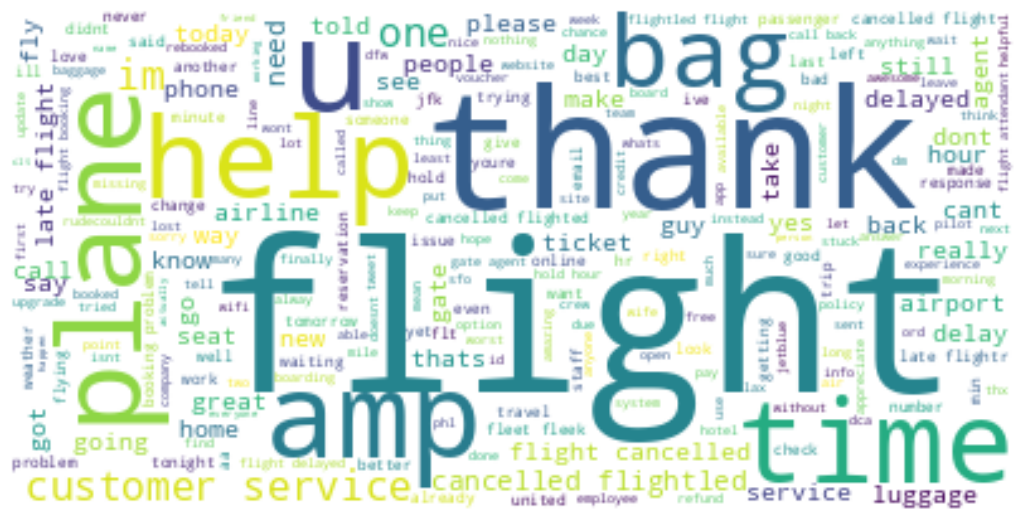

In [218]:
import matplotlib.pyplot as plt
plt.figure(figsize = (13,13))
plt.imshow(worldcloud, interpolation="bilinear")
plt.axis("off")
plt.show()